In [1]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## MDS-MISIS-DL CAPTCHA Symbols Recognition

### Recognise letters of the English alphabet as CAPTCHAs

https://www.kaggle.com/competitions/mds-misis-dl-captchan

----


The goal is to assign a letter from English alphabet to each sample image.\\

For this classification task I have decided to use AlexNet architecture (https://en.wikipedia.org/wiki/AlexNet).
The architecture consists of eight layers: five convolutional layers and three fully-connected layers.
AlexNet uses Rectified Linear Units activation function. 

## Step 0: Load Data


----

### 0.1 Lets define own dataset loader for npy format

In [22]:
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

class NpyImagesDataset(Dataset):
    def __init__(self, images_npy, labels_npy = '', transform = None):
        super(Dataset, self).__init__()
        self.transform = transform       
        self.images = np.load(images_npy)
        if labels_npy:
            self.labels = np.load(labels_npy)
        else:
            self.labels = None
  
    def __len__(self):
        return len(self.images)       
    
    def __getlabel__(self, index):
        if self.labels is not None:
            return self.labels[index]
        return 0

    def __getitem__(self, index):    
        image = self.images[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, self.__getlabel__(index)

### 0.2 Now we need to chain together all standard transformations:

* First we need to convert ndarray to PIL image, we need it to apply further transformations such as 
`Resize`.

* As a second step we resize our images to 227x227 size. This size is chosen to to be faithful to the AlexNet architecture:

$$  o = \left \lfloor \frac{current\_image\_size + 2*padding\_size - filter\_size}{stride\_size} \right \rfloor + 1 $$

For first layer: $ o = \frac{227 - 11}{4} + 1 = 55 $

* Next step is convert our PIL Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. However, we shall be keep in mind that if the PIL Image doesn't belong to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1), then tensors are returned without scaling.

* Last step is normalization. Since there is not analogue to https://www.tensorflow.org/api_docs/python/tf/image/per_image_standardization from TF, I wrote own version.

In [6]:
import torchvision.transforms as transforms
import numpy as np

alex_net_image_size = 227

class PerImageNormalization(object):
    def __call__(self, tensor_image):
        """
        :param img: tensor

        :return: normalized tensor
        """
        mean, std = tensor_image.mean([1,2]), tensor_image.std([1,2])
        normalize = transforms.Normalize(mean = mean, std = std)
        return normalize(tensor_image)

    def __repr__(self):
        return self.__class__.__name__+'()'

image_transformation = transforms.Compose([
    transforms.ToPILImage(), # Convert a tensor or an ndarray to PIL Image
    transforms.Resize((alex_net_image_size, alex_net_image_size)),
    transforms.ToTensor(),
    PerImageNormalization()])

train_dataset = NpyImagesDataset('data/images.npy', 'data/labels.npy', image_transformation)

In [7]:
from torch.utils.data import random_split

validation_set_size = int(0.2 * len(train_dataset))
train_set_size = len(train_dataset) - validation_set_size

torch.manual_seed(42) #Sets the seed for generating random numbers
train_subset, validation_subset = random_split(train_dataset, [train_set_size, validation_set_size])

In [8]:
# First parameter of our network:

BATCH_SIZE = 64

In [9]:
train_dl = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle = True)
val_dl = DataLoader(validation_subset, batch_size = BATCH_SIZE, shuffle = False)

## Step 1: Dataset Visualization


---

Let's visualize some random samples from train dataset alongside with labels.
In English alphabet we have 26 symbols: class with label `0` corresponds to `A` and label `25` corresponds to `Z`.

In [10]:
import string 

alphabet_string = string.ascii_uppercase
alphabet_list = list(alphabet_string)
n_classes = len(alphabet_list)
print("Number of classes: ", n_classes)
print(alphabet_list)

Number of classes:  26
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


#### Also we need to check that all classes are represented in the train dataset:

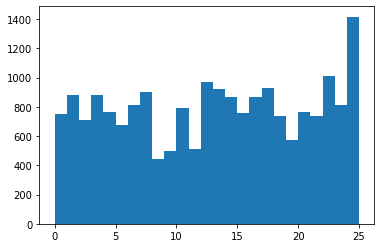

In [11]:
# How many samples of each class there are in dataset

import matplotlib.pyplot as plt

_ = plt.hist(train_subset.dataset.labels, bins=list(range(0, n_classes)))

#### Now lets visualize some random samples:

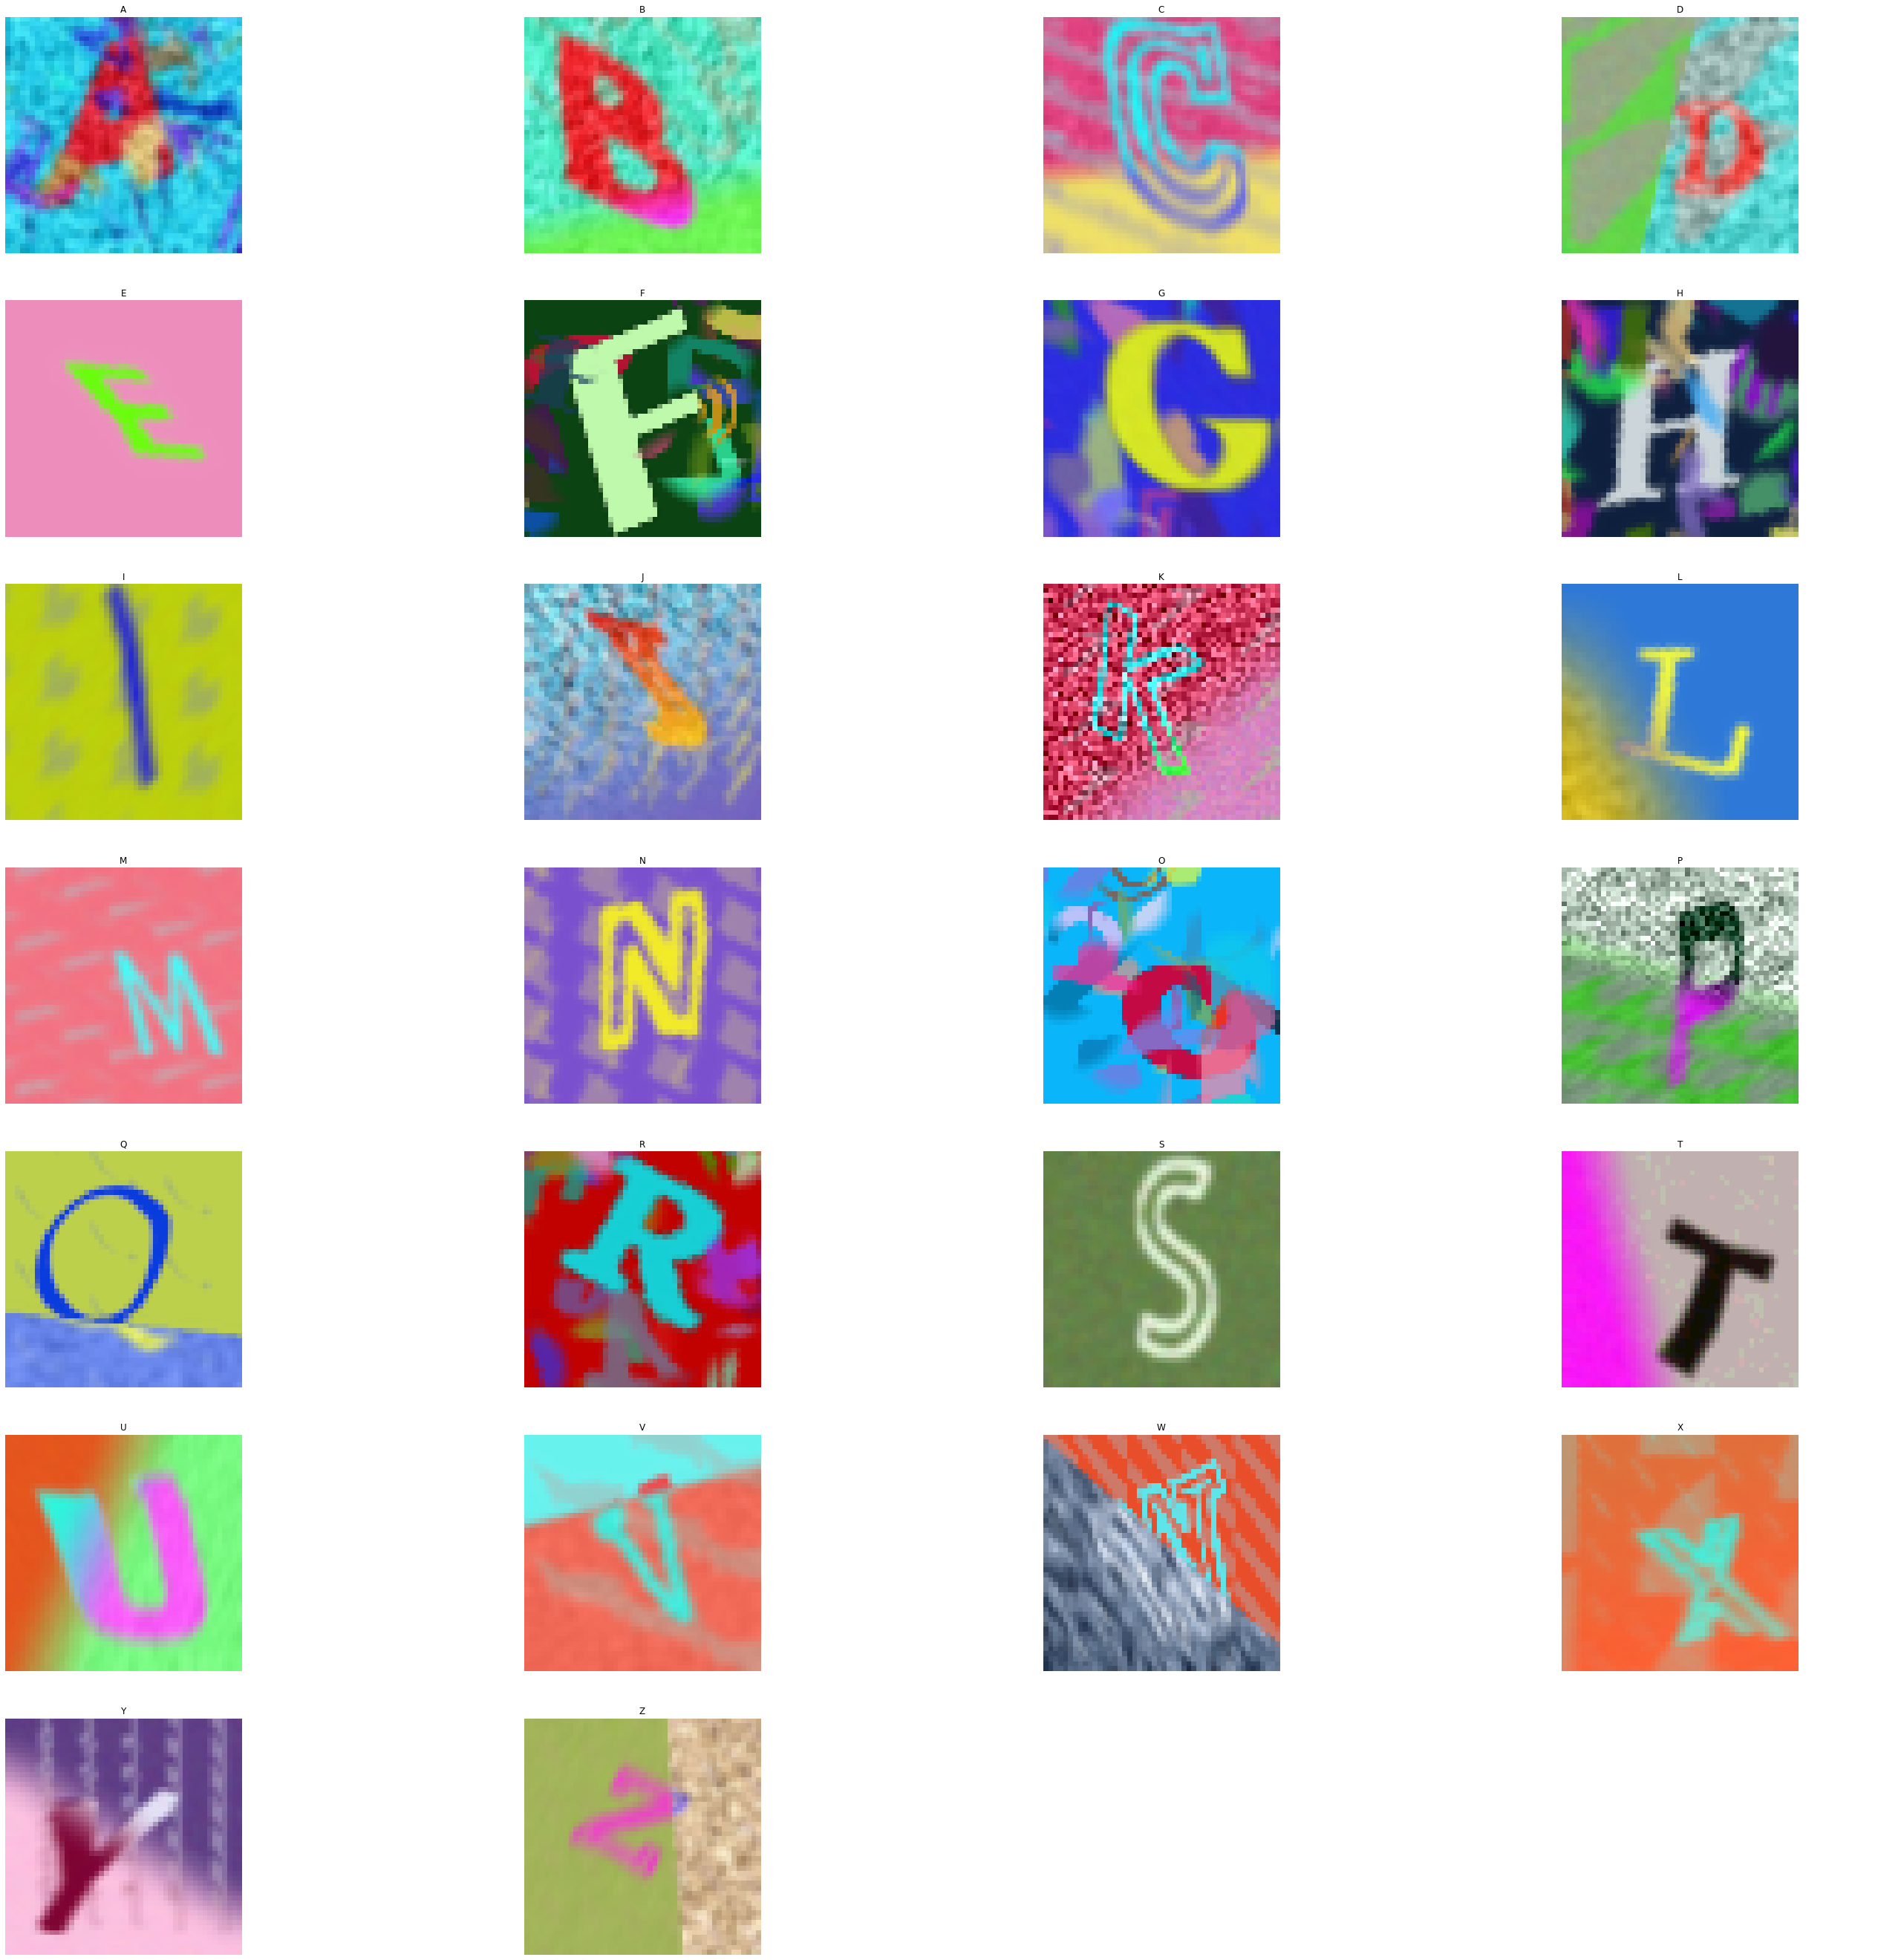

In [12]:
# Original data

%matplotlib inline

image_examples = []

fig, axes = plt.subplots(
             ncols=4,
             nrows=7,
             figsize=(48, 48))

axes = axes.ravel()

for i in range(n_classes):
    idx = np.where(train_subset.dataset.labels == i)
    axes[i].imshow(train_subset.dataset.images[idx][0])
    axes[i].set_title(alphabet_list[i])

for ax in axes:    
    ax.axis('off')
   
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


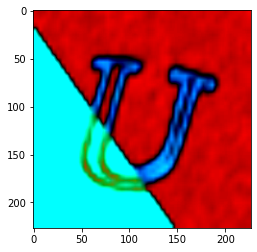

In [13]:
# Normalized and rescaled tensor images

import matplotlib.pyplot as plt

def show_random_sample():
    tensor_image = next(iter(train_dl))[0][0]   
    plt.imshow(tensor_image.permute(1, 2, 0))
    
show_random_sample()

## Step 2: Design Model


----


As was mentioned at the beginning of this Notebook, AlexNet architecture will be used. In addition Batch Normalilzation layers will be used inbetween convolutional layers to reduce internal covariate shift and speed up training.

In [14]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module, BatchNorm2d
from torch.optim import Adam
import torch.nn.functional as F

class AlexCaptchaNet(Module):   
    def __init__(self):
        super(AlexCaptchaNet, self).__init__()
        self.conv1 = Conv2d(in_channels=3,
                            out_channels=96,
                            kernel_size=11,
                            stride=4,
                            padding=0)
        self.batchnorm1 = BatchNorm2d(96)
        self.maxpool = MaxPool2d(kernel_size=3, stride=2)
        
        self.conv2 = Conv2d(in_channels=96,
                               out_channels=256, 
                               kernel_size=5, stride= 1,
                               padding= 2)
        self.batchnorm2 = BatchNorm2d(256)
        
        self.conv3 = Conv2d(in_channels=256,
                               out_channels=384,
                               kernel_size=3,
                               stride= 1,
                               padding= 1)
        self.batchnorm3 = BatchNorm2d(384)
        
        self.conv4 = Conv2d(in_channels=384, 
                               out_channels=384,
                               kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = BatchNorm2d(384)
        
        self.conv5 = Conv2d(in_channels=384,
                               out_channels=256,
                               kernel_size=3, stride=1, padding=1)
        self.batchnorm5 = BatchNorm2d(256)
        
        self.fc1  = Linear(in_features= 9216,
                          out_features= 4096)
        self.fc2  = Linear(in_features= 4096,
                           out_features= 4096)
        self.fc3 = Linear(in_features=4096 , out_features=n_classes) #n_classes = 26

    # Forward pass        
    def forward(self,x):
        x = F.relu(self.conv1(x.float()))
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        
        x = F.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = self.maxpool(x)
        
        x = x.reshape(x.shape[0], -1) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
# Compile model
model = AlexCaptchaNet()

## Step 3: Predict on train data set


In [16]:
LEARNING_RATE = 1e-4
EPOCH_NUM = 50

#### Learning steps

1. Teach model on training data:

* Get batch
* Transfer data batch to target device (cuda or cpu)
`data = data.to(device=device)`
`targets = targets.to(device=device)`
* Explicitly set the gradients to zero before starting to do backpropragation, because PyTorch accumulates the gradients on subsequent backward passes. 
`optimizer.zero_grad()`
* Put data into model
`scores = model(data)`
* Calculate losses
`loss = criterion(scores, targets)`
* Computing the gradients of the loss w.r.t the model parameters
`loss.backward()`
* Update optimizer parameters
`optimizer.step()`
* Update loss for the whole epoch
`loss_ep += loss.item()`

2. Evaluate results on validation data:
* Get batch
* Transfer data batch to target device (cuda or cpu)
`data = data.to(device=device)`
`targets = targets.to(device=device)`
* Predict
`scores = model(data)`
* Get index of maximum probability
`_, predictions = scores.max(1)`
* Compare with ground truth
`num_correct += (predictions == targets).sum()` 


In [17]:
model = model.to(device=device) # send the model for training on either cuda or cpu

## Loss and optimizer
learning_rate = LEARNING_RATE
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr= learning_rate)

for epoch in range(EPOCH_NUM):
    loss_ep = 0   
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores, targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

/home/nastya/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss in epoch 0 :::: 1.9211772992610932
Got 2953 / 4000 with accuracy 73.83
Loss in epoch 1 :::: 0.5729879986047745
Got 3381 / 4000 with accuracy 84.52
Loss in epoch 2 :::: 0.31345457848906516
Got 3474 / 4000 with accuracy 86.85
Loss in epoch 3 :::: 0.20950589983165263
Got 3488 / 4000 with accuracy 87.20
Loss in epoch 4 :::: 0.12382004331052303
Got 3534 / 4000 with accuracy 88.35
Loss in epoch 5 :::: 0.08359186043590307
Got 3538 / 4000 with accuracy 88.45
Loss in epoch 6 :::: 0.08979779512435197
Got 3562 / 4000 with accuracy 89.05
Loss in epoch 7 :::: 0.07104832169041038
Got 3616 / 4000 with accuracy 90.40
Loss in epoch 8 :::: 0.06135837238561362
Got 3582 / 4000 with accuracy 89.55
Loss in epoch 9 :::: 0.032977842116262764
Got 3626 / 4000 with accuracy 90.65
Loss in epoch 10 :::: 0.04842894375184551
Got 3574 / 4000 with accuracy 89.35
Loss in epoch 11 :::: 0.05961781814694404
Got 3608 / 4000 with accuracy 90.20
Loss in epoch 12 :::: 0.03662747255130671
Got 3622 / 4000 with accuracy 90.

In [18]:
# Save model
torch.save(model.state_dict(), './captcha_model.pth')

## Step 4: Predict on final data


In [10]:
model.load_state_dict(torch.load('captcha_model.pth'))

<All keys matched successfully>

In [23]:
dataset_for_submission = NpyImagesDataset('data/images_sub.npy', '', image_transformation)
submission_dl = DataLoader(dataset_for_submission, batch_size = BATCH_SIZE, shuffle = False)

In [24]:
submission_resuls = []
for batch_idx, (data, targets) in enumerate(submission_dl):
    ## Forward Pass
    scores = model(data.cuda())
    softmax = torch.exp(scores).cpu()
    prob = list(softmax.detach().numpy())
    predictions = np.argmax(prob, axis=1)
    submission_resuls.append(predictions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


W tensor(22, device='cuda:0')


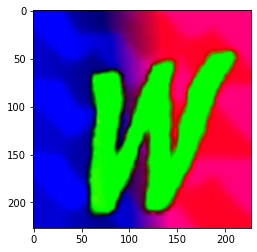

In [55]:
# Visualize random sample and predicted label

import matplotlib.pyplot as plt
from random import randrange

sample_tensor_image = next(iter(submission_dl))[0][randrange(BATCH_SIZE)]
plt.imshow(sample_tensor_image.permute(1, 2, 0))

sample_tensor_image = sample_tensor_image.to(device)
sample_tensor_image = sample_tensor_image[None]
sample_tensor_image = sample_tensor_image.type('torch.cuda.FloatTensor')
predicted_result = model(sample_tensor_image)
print(alphabet_list[predicted_result.argmax()], predicted_result.argmax())

### 4.0 Store predicted results to submission file

In [57]:
import pandas as pd 

# Write data to submission file
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8


In [58]:
sample_submission['Category'] = np.concatenate(submission_resuls)
sample_submission.to_csv('captcha_submission.csv', index=False)
sample_submission.head(10)

,Id,Category
0,0,19
1,1,8
2,2,3
3,3,12
4,4,10
5,5,7
6,6,5
7,7,17
8,8,23
9,9,22
